In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[145]:


import torch
import random
#random.seed(1995)


# # Import sample of all datasets:
# 

# In[2]:


#SQuAD

import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

squad_contexts, squad_questions, squad_answers = read_squad('preproc_datasets/train-v2.0.json')
random_index = random.sample(range(len(squad_answers)),20)
squad_contexts = [squad_contexts[index] for index in random_index]
squad_questions = [squad_questions[index] for index in random_index]
squad_answers = [squad_answers[index] for index in random_index]


# In[64]:


# MNLI 

import jsonlines

def parse_mnli(path):
    sentences_a = []
    sentences_b = []
    labels = []
    with open(path, "r+", encoding="utf8") as f:
        for item in jsonlines.Reader(f):
            sentences_a.append(item['sentence1'])
            sentences_b.append(item['sentence2'])
            labels.append(item['gold_label'])
    
    return sentences_a,sentences_b,labels

mnli_a, mnli_b, mnli_labels = parse_mnli('./preproc_datasets/multinli_1.0_train.json')
random_index = random.sample(range(len(mnli_a)),20)
mnli_a = [mnli_a[index] for index in random_index]
mnli_b = [mnli_b[index] for index in random_index]
mnli_labels = [mnli_labels[index] for index in random_index]

label_encode = {'contradiction': 0,
                'neutral': 1,
                'entailment': 2}
mnli_labels = [label_encode[label] for label in mnli_labels]


# In[65]:


# BioASQ Factoid

import pandas as pd

with open('preproc_datasets/BioASQ-train-factoid-8b-snippet-annotated.json', 'rb') as f:
    bio_factoid_raw = json.load(f)['data'][0]['paragraphs']
bio_factoid = [q['qas'][0] for q in bio_factoid_raw]
for i in range(len(bio_factoid)):
    bio_factoid[i]['context'] = bio_factoid_raw[i]['context']
bio_factoid_df = pd.DataFrame.from_dict(bio_factoid)
bio_factoid_df['answer_text'] = bio_factoid_df.answers.map(lambda x: x[0]['text'])
bio_factoid_df['answer_start'] = bio_factoid_df.answers.map(lambda x: x[0]['answer_start'])
bio_factoid_df.drop('answers', axis = 1, inplace = True)
#bio_factoid_df.head()

bio_factoid_questions = list(bio_factoid_df.question)
bio_factoid_contexts = list(bio_factoid_df.context)
bio_factoid_answers = [{'text': row['answer_text'],
                       'answer_start': row['answer_start']} 
                      for index, row in bio_factoid_df.iterrows()]
# Sampling
random_index = random.sample(range(len(bio_factoid_questions)),20)

bio_factoid_questions = [bio_factoid_questions[index] for index in random_index]
bio_factoid_contexts = [bio_factoid_contexts[index] for index in random_index]
bio_factoid_answers = [bio_factoid_answers[index] for index in random_index]



print('Done importing data')


# Import Model and Tokenizer 

from transformers import BertTokenizer, BertTokenizerFast

tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1", 
                                          do_lower_case=True,
                                          padding = True,
                                          truncation=True,
                                          add_special_tokens = True,
                                          model_max_length = 1000000000)

tokenizer_fast = BertTokenizerFast.from_pretrained('dmis-lab/biobert-base-cased-v1.1', 
                                          do_lower_case=True,
                                          padding = True,
                                          truncation=True,
                                          add_special_tokens = True,
                                          model_max_length = 1000000000)


# In[67]:


# SQuAD processing functions
from train.squad_processing import add_end_idx, add_token_positions

add_end_idx(squad_answers,squad_contexts)
add_end_idx(bio_factoid_answers,bio_factoid_contexts)


# # Tokenization

# In[68]:

print("Tokenizing")

# SQuAD

squad_encodings = tokenizer_fast(squad_contexts,squad_questions,
                                 add_special_tokens=True,
                                 truncation=True,
                                 padding=True,
                                 max_length=500)

# Processing of token positions
add_token_positions(squad_encodings, squad_answers, tokenizer_fast)


# In[69]:


# MNLI

mnli_encodings = tokenizer(mnli_a,mnli_b, 
                        add_special_tokens=True,
                        max_length=500,
                        truncation=True, 
                        padding=True)
mnli_encodings['labels'] = mnli_labels


# In[70]:


# BioASQ

bio_factoid_encodings = tokenizer_fast(bio_factoid_contexts,bio_factoid_questions,
                               add_special_tokens=True,
                               truncation=True,
                               padding=True,
                               max_length=500)

# Processing of token positions
add_token_positions(bio_factoid_encodings, bio_factoid_answers,tokenizer_fast)


# In[71]:


# Defining Datasets 

from torch.utils.data import Dataset

class MnliDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        #print(self.encodings['start_positions'][idx])
        #{key: torch.tensor(val[idx], dtype = torch.long) for key, val in self.encodings.items()}
        return {'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype = torch.long),
                'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype = torch.long),
                'token_type_ids': torch.tensor(self.encodings['token_type_ids'][idx], dtype = torch.long),
                'labels': torch.tensor(self.encodings['labels'][idx], dtype = torch.long)
               }

    def __len__(self):
        return len(self.encodings.input_ids)
    
class SquadDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        #print(self.encodings['start_positions'][idx])
         #{key: torch.tensor(val[idx], dtype = torch.long) for key, val in self.encodings.items()}
        return {'input_ids':torch.tensor(self.encodings['input_ids'][idx],dtype = torch.long),
         'attention_mask':torch.tensor(self.encodings['attention_mask'][idx],dtype = torch.long),
         'start_positions':torch.tensor(self.encodings['start_positions'][idx],dtype = torch.long),
         'end_positions':torch.tensor(self.encodings['end_positions'][idx],dtype = torch.long)}

    def __len__(self):
        return len(self.encodings.input_ids)


# In[72]:

print('MNLI')

train_mnli = MnliDataset(mnli_encodings)
train_squad = SquadDataset(squad_encodings)
train_bio_factoid = SquadDataset(bio_factoid_encodings)


# In[27]:


from transformers import BertPreTrainedModel, BertModel
from torch import nn
from torch.nn import CrossEntropyLoss


# In[106]:


class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    """
    def __init__(self, config, num_labels=3):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        #self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        pooled_output = self.bert(input_ids, token_type_ids, attention_mask)[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
    
        return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True


# In[101]:


mnli_model = BertForMultiLabelSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


# In[98]:

from torch.nn import DataParallel
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

mnli_model.to(device)
mnli_model.train()

#mnli_model = DataParallel(mnli_model, device_ids = [0,1,2,3])

train_loader_mnli = DataLoader(train_mnli, batch_size= 4, shuffle=True)

optim = AdamW(mnli_model.parameters(), lr=5e-5)


# In[105]:


from barbar import Bar
for epoch in range(3):
    for i,batch in enumerate(Bar(train_loader_mnli)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = mnli_model(input_ids, 
                                attention_mask=attention_mask, 
                                token_type_ids = token_type_ids,
                                labels = labels)

        loss_fct = CrossEntropyLoss()
        loss = loss_fct(outputs, labels)
        #loss = outputs.loss
        loss.sum().backward()
        optim.step()
mnli_model.eval()


# In[111]:


from transformers.modeling_outputs import QuestionAnsweringModelOutput


# In[112]:


class BertForQuestionAnswering(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


# In[116]:

print('SQUAD')
squad_model = BertForQuestionAnswering.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


# In[120]:


squad_model.load_state_dict(mnli_model.state_dict(), 
                            strict=False)


# In[121]:


squad_model.to(device)
squad_model.train()

#squad_model = DataParallel(squad_model, device_ids = [0,1,2,3])


train_loader_squad = DataLoader(train_squad, batch_size=4, shuffle=True)

optim = AdamW(squad_model.parameters(), lr=5e-5)


# In[122]:


for epoch in range(3):
    for i,batch in enumerate(Bar(train_loader_squad)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        start_positions = batch['start_positions'].to(device, dtype = torch.long)
        end_positions = batch['end_positions'].to(device, dtype = torch.long)
        outputs = squad_model(input_ids, 
                        attention_mask=attention_mask, 
                        start_positions=start_positions, 
                        end_positions=end_positions)
        loss = outputs[0]
        loss.sum().backward()
        optim.step()
#squad_model.eval()


# In[123]:
print('BioAsq')

#squad_model.to(device)
squad_model.train()

train_loader_factoid = DataLoader(train_bio_factoid, batch_size=4, shuffle=True)

#optim = AdamW(squad_model.parameters(), lr=5e-5)


# In[124]:


# Train on BioAsq

for epoch in range(3):
    for i,batch in enumerate(Bar(train_loader_factoid)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        start_positions = batch['start_positions'].to(device, dtype = torch.long)
        end_positions = batch['end_positions'].to(device, dtype = torch.long)
        outputs = squad_model(input_ids, 
                        attention_mask=attention_mask, 
                        start_positions=start_positions, 
                        end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
squad_model.eval()


# In[ ]:

print('Saving...')

torch.save({
            'epoch': 3,
            'model_state_dict': squad_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            },'try_small_mnli_squad.pt')

Done importing data
Tokenizing
MNLI


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Be

20/20: [=========================>......] - ETA 11.3s
20/20: [=========================>......] - ETA 11.1s
20/20: [=========================>......] - ETA 11.0s
SQUAD


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized f

20/20: [=========================>......] - ETA 11.5s
20/20: [=========================>......] - ETA 11.0s
20/20: [=========================>......] - ETA 10.4s
BioAsq
20/20: [=========================>......] - ETA 6.9ss
20/20: [=========================>......] - ETA 6.0ss
20/20: [=========================>......] - ETA 6.2ss
Saving...


In [61]:
test_question = "What does the pembrolizumab companion diagnostic test assess?"
test_context = "The initial approval and subsequent studies of pembrolizumab required and utilized a companion diagnostic test, Dako's IHC 22C3, to assess PD-L1 status of patients."

    

inputs = tokenizer_fast(test_question, 
                   test_context, 
                   truncation=True, 
                   padding=True,
                   max_length=500, 
                   return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
text_tokens = tokenizer_fast.convert_ids_to_tokens(input_ids)
outputs = squad_model(**inputs)
answer_start_scores = outputs.start_logits
# Get the most likely beginning of answer 
answer_start = torch.argmax(answer_start_scores)
answer_end_scores = outputs.end_logits[0][answer_start:]
# Get the most likely end of answer 
answer_end = torch.argmax(answer_end_scores) + 1  
answer = tokenizer_fast.convert_tokens_to_string(
    tokenizer_fast.convert_ids_to_tokens(
        input_ids[answer_start:(answer_start+answer_end+1)]))

In [2]:
outputs

QuestionAnsweringModelOutput(loss=tensor(1.0103, grad_fn=<DivBackward0>), start_logits=tensor([[-3.4516,  2.7427, -0.4152,  0.1761,  0.1918, -0.4189, -2.5025, -3.1370,
         -1.4827, -2.6535, -0.9092, -2.6737, -2.3905, -0.0488, -2.1532, -0.2783,
          0.5209, -1.6242, -0.5960, -1.5855,  0.2661, -1.0698,  0.9707, -0.4045,
          1.7623,  0.5302, -1.9339, -0.8773, -2.2173, -2.8530, -2.7489,  2.0464,
         -0.1324, -1.4405, -2.3707, -3.6621, -4.1442, -1.4680, -3.8297, -2.3066,
         -3.2082, -3.5331, -2.3637, -3.3932, -3.1683,  1.2367,  0.0141, -2.1442,
         -2.4285, -4.0495, -1.9655, -3.9713, -4.2164, -4.1126, -3.9640, -4.2063,
         -4.2654, -4.1014, -4.1493, -4.1455, -4.1077, -4.1424, -4.0190, -4.3712,
         -4.0388, -4.2502, -4.2070, -3.8898, -4.2001, -4.1015, -4.3487, -4.2094,
         -4.2735, -4.0721, -4.2352, -4.2720, -4.2234, -4.1372, -4.1905, -4.2122,
         -4.2407, -4.1701, -4.2063, -4.0683, -4.0178, -4.2388, -4.1603, -4.0355,
         -4.1857, -4.1

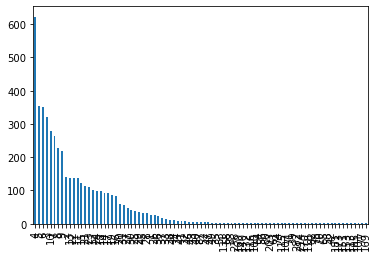

In [77]:
bio_factoid_df.answer_text.map(lambda x: len(x)).value_counts().plot(kind='bar')

In [81]:
bio_factoid_df['len'] = bio_factoid_df.answer_text.map(lambda x: len(x))

In [84]:
squad_contexts, squad_questions, squad_answers = read_squad('preproc_datasets/train-v2.0.json')
squad_df = pd.DataFrame({'question': squad_questions,
                        'context' :  squad_contexts,
                        'answer_text' : [a['text'] for a in squad_answers]})

In [89]:
squad_df['len'] = squad_df.answer_text.map(lambda x: len(x))

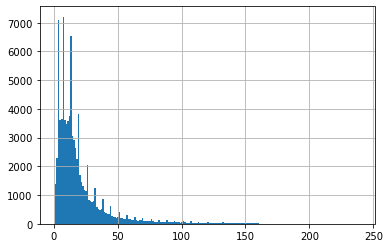

In [92]:
squad_df.len.hist()

In [96]:
squad_df.isnull().sum()

question       0
context        0
answer_text    0
len            0
dtype: int64